In [19]:
import argparse
import os
import random
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.pyplot import imshow, imsave


In [20]:
# This cell is only for Google Colaboratory
#from google.colab import drive
#drive.mount('/content/gdrive')

## Defining parameters

In [21]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 100

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3 # with mnist 1, other 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Number of labels
num_labels = 4 # we will use 4, CIFAR and MNIST has 10

In [22]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


Files already downloaded and verified


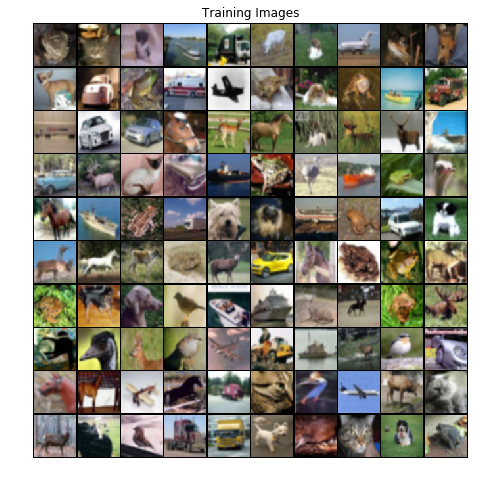

In [23]:
## Cifar
transform=torchvision.transforms.Compose([
                                 torchvision.transforms.Resize(image_size),
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize(
                                 (0.5,0.5,0.5), (0.5,0.5,0.5))])

dataset =  torchvision.datasets.CIFAR10('/files/', train=True, download=True, transform = transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE),nrow = 10, padding=2, normalize=True).cpu(),(1,2,0)))

Number of pictures in the dataset:  19800


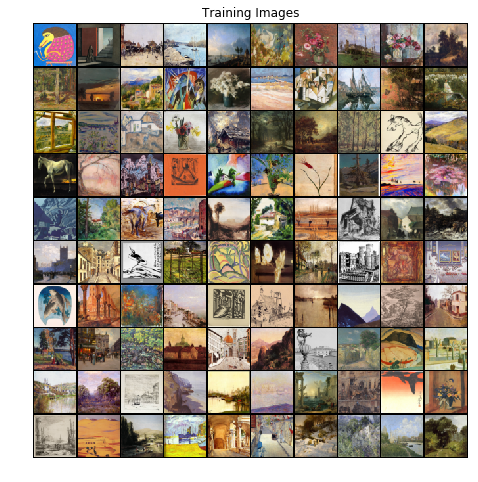

In [24]:
dataroot = []
dataset = []
# Create new dataset from images
for i in range(1,num_labels + 1):
    dataset.append(dset.ImageFolder(root=F"..\small_imageslandscapes\Label{i}",
                           transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])))

      
# Create labels for our dataset
# Labels are in i
for i in range(len(dataset)):
    for j in range(len(dataset[i])):
        dataset[i].samples[j] = (dataset[i].samples[j][0],i)
        
# Combine all the datasets
newdataset = torch.utils.data.ConcatDataset(dataset)
dataloader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                        shuffle=True, num_workers=workers)

# Decide which device we want to run on
#DEVICE = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch,labels = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(DEVICE), padding=2, nrow = 10, normalize=True).cpu(),(1,2,0)))

print("Number of pictures in the dataset: ",len(dataloader.dataset))

In [25]:
# Added or isinstance nn.Linear
def normal_init(m, mean=0., std=0.02):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear): 
        m.weight.data.normal_(mean, std)
        #m.bias.data.zero_()
print(len(dataloader.dataset))     

19800


In [26]:
class Discriminator(nn.Module):
    """
        5 conv layers
        combining conv output with labels
        1 Dense layer for each output
        2 outputs
        
    """
    def __init__(self, num_classes=10, nc=3, ndf = 16,batch_size = 100):
        super(Discriminator, self).__init__()
        
        self.ndf = ndf
        self.batch = batch_size
        
        # Layers
        self.conv1 = nn.Conv2d(nc, ndf ,5, 2, 2, bias=False)
        #self.bn1 = nn.BatchNorm2d(ndf) # First layer doesnt need batchnorm (?)
        
        self.conv2 = nn.Conv2d(ndf,ndf * 2, 5, 2, 2, bias = False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
        
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 5, 2, 2, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 5, 2, 2, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)

        self.conv5 = nn.Conv2d(ndf * 8, ndf * 16, 5, 2, 2, bias=False)
        self.bn5 = nn.BatchNorm2d(ndf * 16)
        
        self.LinAux = nn.Linear(16*ndf*2*2,num_classes)
        self.LinD = nn.Linear(16*ndf*2*2,1)
        
        # Activation funcs and weight init
        self.act = nn.LeakyReLU(0.2,inplace=True)
        self.out1 = nn.Sigmoid()
        self.out2 = nn.LogSoftmax(dim=1)
        self.weight_init(mean = 0., std = 0.02)

        


        
        
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    
    def forward(self, x, y=None):
        #3x64x64 --> 16x32x32
        #print(x.shape)
        x = self.act(self.conv1(x))
        #print(x.shape)
        #16x32x32 --> 32x16x16
        x = self.act(self.bn2(self.conv2(x)))
        #print(x.shape)
        #32x16x16 --> 64x8x8
        x = self.act(self.bn3(self.conv3(x)))
        #print(x.shape)
        #64x8x8 --> 128x4x4
        x = self.act(self.bn4(self.conv4(x)))
        #print(x.shape)
        #128x4x4 --> 256x2x2
        x = self.act(self.bn5(self.conv5(x)))
        #print(x.shape)
        x = x.view(self.batch,-1)
        x_ax = self.LinAux(x)
        #print(x_ax.shape)
        x_d = self.LinD(x)
        #print(x_d.shape)
        #x = self.act(self.conv1(x))
        #y = self.act(self.convlabel(y))
        #x = torch.cat([x,y],1)
        #x = self.act(self.bn1(self.conv2(x)))
        #x = self.act(self.bn2(self.conv3(x)))
        #x = self.act(self.bn3(self.conv4(x)))
        #x = self.conv5(x)
        return self.out1(x_d),self.out2(x_ax)

In [13]:
#Testing Disc dimensions:
inp_tensor = real_batch
print('Input:',inp_tensor.shape)
#labels = real_batch[1]
#print(labels.shape)
#onehot = torch.zeros(num_labels, num_labels)
#onehot = onehot.scatter_(1, torch.LongTensor([range(num_labels)]).view(num_labels,1), 1).view(num_labels, num_labels, 1, 1)
#y_label = onehot[labels]
#print('onehot:',y_label[0],'\nlabel: ',labels[0],'\n')


D = Discriminator()
print(D)
predictions_real, predictions_labels = D(inp_tensor)

print('\nNumber of Trainable parameters:',sum(p.numel() for p in D.parameters() if p.requires_grad))

Input: torch.Size([100, 3, 64, 64])
Discriminator(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LinAux): Linear(in_features=1024, out_features=10, bias=True)
  (LinD): Linear(in_features=1024, out_features=1, bias=True)
  (act): LeakyReL

In [27]:
class Generator(nn.Module):
    """
        Generator
    """
    def __init__(self, input_size = 100, num_classes=10,ngf = 16,batch_size=batch_size):
        super(Generator, self).__init__()
        # Linear output size ?
        self.n_classes = num_classes
        self.b_size = batch_size
        
        self.Lin1 = nn.Linear(input_size+num_classes,ngf*32)
        #Batchnorm after linear layer
        self.bn = nn.BatchNorm1d(ngf*32)
        
        self.conv1 = nn.ConvTranspose2d(ngf*32, ngf*16, 4, 1, 0,bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*16)
        
        
        self.conv2 = nn.ConvTranspose2d(ngf * 16,ngf * 8, 4, 2, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(ngf * 8)

        self.conv3 = nn.ConvTranspose2d(ngf * 8,ngf * 4, 4, 2, 1, bias = False)
        self.bn3 = nn.BatchNorm2d(ngf * 4)
        
        self.conv4 = nn.ConvTranspose2d(ngf * 4,ngf * 2, 4, 2, 1, bias = False)
        self.bn4 = nn.BatchNorm2d(ngf * 2)
        
        self.conv5 = nn.ConvTranspose2d(ngf*2, nc, 4, 2, 1, bias = False)
        
        # Activation and output func + weight init
        self.out = nn.Tanh()
        self.act = nn.LeakyReLU(0.2)
        self.weight_init(mean = 0., std = 0.02)
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x, y):
        x = torch.cat([x,y],1)
        x = x.view(self.b_size,100+self.n_classes)
        x = self.Lin1(x)
        x = x.view(self.b_size,-1,1,1)
        x = self.act(self.bn1(self.conv1(x)))
        #print(x.shape)
        x = self.act(self.bn2(self.conv2(x)))
        #print(x.shape)
        x = self.act(self.bn3(self.conv3(x)))
        #print(x.shape)
        x = self.act(self.bn4(self.conv4(x)))
        #print(x.shape)
        x = self.conv5(x)
        #print(x.shape)
        
        return self.out(x)

Input: torch.Size([100, 100, 1, 1])
Label: torch.Size([100, 4, 1, 1]) 

Generator(
  (Lin1): Linear(in_features=104, out_features=512, bias=True)
  (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d

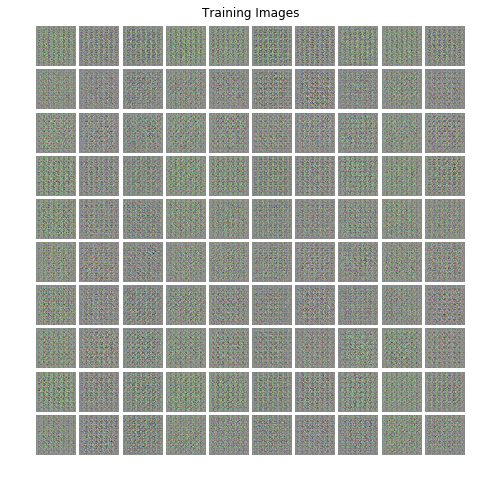

In [13]:
# Testing Gen dimensions:
inp_noise = torch.randn((batch_size, 100, 1, 1))
inp_noise = Variable(inp_noise.to(DEVICE))
print('Input:',inp_noise.shape)
#
#        
y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
onehot = torch.zeros(num_labels, num_labels)
onehot = onehot.scatter_(1, torch.LongTensor([range(num_labels)]).view(num_labels,1), 1).view(num_labels, num_labels, 1, 1)
y_label = onehot[y_rand]
y_label = Variable(y_label.to(DEVICE))
#
print('Label:',y_label.shape,'\n')
G = Generator(ngf = ngf, num_classes=num_labels)
print(G)
Fake_images = G(inp_noise, y_label)
with torch.no_grad():
    fake_images = G(inp_noise, y_label)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE), padding=5,pad_value = 1, nrow = 10, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
D = Discriminator(num_classes = num_labels,ndf=ndf,batch_size=batch_size).to(DEVICE)
G = Generator(num_classes=num_labels,ngf=ngf,batch_size=batch_size).to(DEVICE)

# Setup Adam optimizers for both G and D
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

#Schedulers if necessary
scheduler1 = torch.optim.lr_scheduler.StepLR(D_opt, step_size=10, gamma=0.75, last_epoch=-1) 
scheduler2 = torch.optim.lr_scheduler.StepLR(G_opt, step_size=10, gamma=0.75, last_epoch=-1)

dis_criterion = nn.BCELoss()
aux_criterion = nn.NLLLoss()

In [ ]:
# Initialize stuff before training
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100
max_epoch = 1000
path1 = F"/content/gdrive/My Drive/Colab Notebooks/ACGAN"  

In [ ]:
G_losses = []
D_losses = []
img_list = []

real = 1 # Discriminator Label to real
fake = 0 # Discriminator Label to fake

fixed_y = torch.zeros(num_labels, 1)
y_label = torch.zeros(batch_size, num_labels)

# Creates onehot array, that is diagonal matrix in tensor from.
onehot = torch.zeros(num_labels, num_labels)
onehot = onehot.scatter_(1, torch.LongTensor([range(num_labels)]).view(num_labels,1), 1).view(num_labels, num_labels, 1, 1)



# Fixed Y labels for evaluation
y_0 = torch.full((batch_size//num_labels, 1), 0).type(torch.LongTensor).squeeze()
y_fixed_labels = torch.zeros(batch_size, num_labels)
for i in range(1,num_labels):
    desired_label = i
    y_fixed = torch.full((batch_size//num_labels, 1), desired_label).type(torch.LongTensor).squeeze()

    y_0 = torch.cat((y_0, y_fixed), 0)

y_fixed_labels = onehot[y_0]
y_fixed_labels= Variable(y_fixed_labels.to(DEVICE))
fixed_noise = torch.randn((batch_size, 100, 1, 1))
fixed_noise = Variable(fixed_noise.to(DEVICE))

dis_label = torch.FloatTensor(batch_size).to(DEVICE)
aux_label = torch.LongTensor(batch_size).to(DEVICE)

for epoch in range(max_epoch):
    #scheduler1.step()
    #scheduler2.step()
    for idx, (images, labels) in enumerate(dataloader):

        # Training Discriminator with real data
        D.zero_grad()
        dis_label.data.fill_(real)
        aux_label.data.copy_(labels)
        predictions_real, predictions_label = D(images.to(DEVICE))
        
        dis_errD_real = dis_criterion(predictions_real.squeeze(), dis_label)
        aux_errD_real = aux_criterion(predictions_label.squeeze(), aux_label)
        errD_real = 0.5*(dis_errD_real + aux_errD_real)
        errD_real.backward()
        D_x = predictions_real.data.mean()
        
        ###
        # Training Discriminator with fake data
        ###
        z = torch.randn((batch_size, 100, 1, 1))
        z = Variable(z.to(DEVICE))
        y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
        y_label = onehot[y_rand]
        y_label = Variable(y_label.to(DEVICE))
        
        fake_images = G(z,y_label)
        aux_label.data.copy_(y_rand)
        dis_label.data.fill_(fake)
        predictions_fake, predictions_label = D(fake_images.detach())
        
        dis_errD_fake = dis_criterion(predictions_fake.squeeze(), dis_label)
        aux_errD_fake = aux_criterion(predictions_label.squeeze(), aux_label)
        errD_fake = 0.5*(dis_errD_fake + aux_errD_fake)
        errD_fake.backward()
        D_G_z1 = predictions_fake.data.mean()
        #acc_fake = accuracy_score(aux_label.data.cpu(), predictions_label.data.squeeze().cpu()).to(DEVICE)
        errD = 0.5*(errD_real + errD_fake)
        D_opt.step()
        
        ###
        # Training Generator
        ###
        
        G.zero_grad()
        
        z = torch.randn((batch_size, 100, 1, 1))
        z = Variable(z.to(DEVICE))
        y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
        y_label = onehot[y_rand]
        y_label = Variable(y_label.to(DEVICE))
        
        dis_label.data.fill_(real)  # fake labels are real for generator cost
        predictions_fake, predictions_label = D(fake_images)
        dis_errG = dis_criterion(predictions_fake.squeeze(), dis_label)
        aux_errG = aux_criterion(predictions_label.squeeze(), aux_label)
        errG = 0.5*(dis_errG + aux_errG)
        errG.backward()
        D_G_z2 = predictions_fake.data.mean()
        G_opt.step()
        
        
        if step % 10 == 0:
            print('[%d/%d][%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, max_epoch, step,
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            #print('Acc for real images: %.4f\tAcc for fake images: %.4f'
            #      % (acc_real,acc_fake))
            # Output training stats
        

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
        step += 1
        if (step % 10 == 0):
            print("Figure number: ", epoch+1)
            # generation to image
            G.eval()

            # Create labels from 0 to 9 (tensor is 100 long)

            # save image

            #torch.save(netG.state_dict(), os.path.join(path2, 'G--{}.ckpt'.format(epoch+1)))
            #torch.save(netD.state_dict(), os.path.join(path3, 'D--{}.ckpt'.format(epoch+1)))
            with torch.no_grad():
                fake_images = G(fixed_noise,y_fixed_labels).detach().cpu()

            plt.figure(figsize=(8,8))
            plt.axis("off")
            plt.title("Training Images")
            plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE), padding=5,pad_value = 1, nrow = 10, normalize=True).cpu(),(1,2,0)))
            plt.show()
            G.train()
    if (epoch % 25 == 0):
        print("1")
        #img_list.append(vutils.make_grid(fake_images, padding=2, nrow = 10, normalize=True))
        #vutils.save_image((fake_images.data), os.path.join(path1, 'fake_images-{}.png'.format(epoch+1)), nrow = 10, normalize=True)
        #torch.save(G.state_dict(), os.path.join(path1, 'G--{}.ckpt'.format(epoch+1)))
        #torch.save(D.state_dict(), os.path.join(path1, 'D--{}.ckpt'.format(epoch+1)))
        
        
        

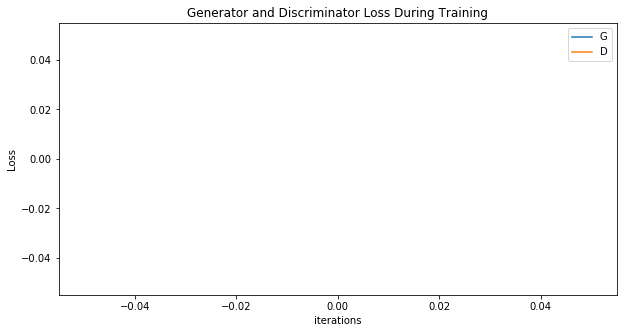

In [24]:
#Labels of Cifar-10 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

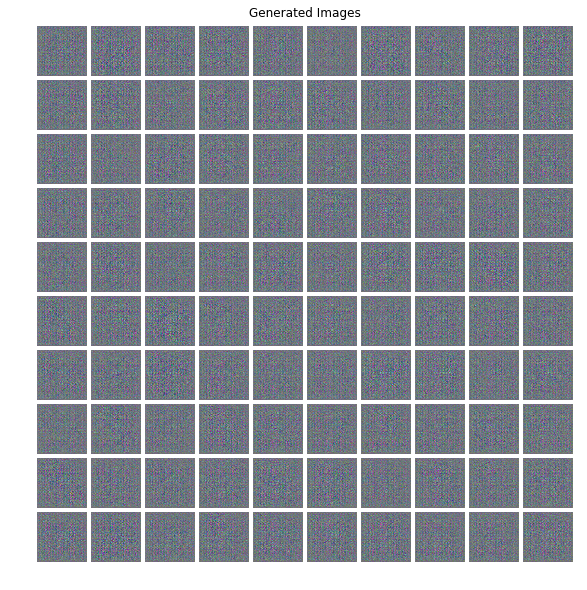

In [38]:
## Luodaan kuvia:
onehot = torch.zeros(num_labels, num_labels)
onehot = onehot.scatter_(1, torch.LongTensor([range(num_labels)]).view(num_labels,1), 1).view(num_labels, num_labels, 1, 1) 
batch_size = 100
G.eval()
z = torch.randn((batch_size, 100, 1, 1))
z = Variable(z.to(DEVICE))
y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
y_rand = torch.ones(batch_size,1).type(torch.LongTensor).squeeze() * 3# specific label
y_label = onehot[y_rand]
y_label = Variable(y_label.to(DEVICE))
with torch.no_grad():
    fake_images = G(z,y_label).detach().cpu()

plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE), padding=5,pad_value = 1, nrow = 10, normalize=True).cpu(),(1,2,0)))
plt.show()
a = G.train()



In [43]:
k = 8
interpolations = np.linspace(fixed_noise[0].cpu().view(-1),fixed_noise[9].cpu().view(-1),num=k)
new_noise = torch.tensor(interpolations).to(DEVICE)
new_noise = new_noise.view(k,100,1,1).to(DEVICE)
new_label = torch.zeros(k,2,1,1).to(DEVICE)
for i in range(k):
    #Manually setting the correct label for generated images
    new_label[i][0] = 1  
  
  



z = torch.randn((batch_size, 100, 1, 1))
z = Variable(z.to(DEVICE))
y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
y_rand = torch.ones(batch_size,1).type(torch.LongTensor).squeeze() * 0 # specific label
y_lab = onehot[y_rand]
y_lab = Variable(y_lab.to(DEVICE))

# Voisi taas tehdä järkevämmin, mutta pitäisi muokata generaattoria
y_lab[:k] = new_label
z[:k] = new_noise
G.eval()
with torch.no_grad():
    inter_images = G(z,y_lab).detach().cpu()
plt.figure(figsize=(25,25))
plt.axis("off")
plt.title("Interpolated Images")
plt.imshow(np.transpose(vutils.make_grid(inter_images.to(DEVICE)[:k], padding=5,pad_value = 1, nrow = 9, normalize=True).cpu(),(1,2,0)))
plt.show()

<class 'torch.Tensor'>


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Number of pictures in the dataset:  11
2977.5685022036487
(array([0], dtype=int64), array([4], dtype=int64))


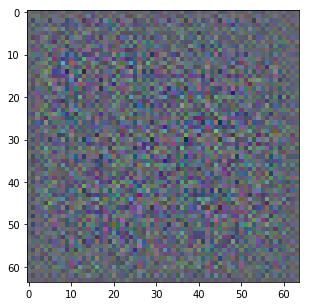

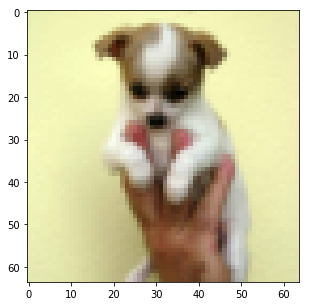

In [49]:
import scipy.spatial.distance as scp
dataset = []
Kuva_nmro = 92
flatted = fake_images[Kuva_nmro].view(1,-1) # Tähän kuva mille etitään vastaavanlaista

N1 = 11 # Kuvien määrä siinä classissa mistä haetaan, pitää määritellä dataset uudestaan
N2 = 66 # Label2 66 kuvaa

for i in range(1,2):
    dataset.append(dset.ImageFolder(root=F"./Dog_images/Label{i}",
                           transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])))

      
# Create labels for our dataset
# Labels are in i
for i in range(len(dataset)):
    for j in range(len(dataset[i])):
        dataset[i].samples[j] = (dataset[i].samples[j][0],i)
        
# Combine all the datasets
batch_s = N1 

newdataset = torch.utils.data.ConcatDataset(dataset)
dataloader = torch.utils.data.DataLoader(newdataset, batch_size=batch_s,
                                        shuffle=True, num_workers=workers)

print("Number of pictures in the dataset: ",len(dataloader.dataset))
real_batch = next(iter(dataloader))

images = real_batch[0] # Tähän kaikki datasetin kuvat


flat = torch.zeros(N1,3*64*64)
for i in range(N1):
    flat[i] = images[i].view(-1) # litistetään kuvat

#print(flat.shape)
#flatted = torch.cat([flatted,flat],0)
#print(flatted.shape)
dist1 = scp.cdist(flatted,flat,'cityblock') # Cityblock pitäisi olla L1 etäisyys

#Y = scp.squareform(scp.pdist(flatted,'cityblock')) 
#dist = scp.pdist(flatted,'cityblock')[0:N]
Ymin = np.min(dist1) # Etsitään pienin etäisyys (= samanlaisin kuva)
print(Ymin)
indx = np.where(dist1==Ymin) # Etsitään sen kuvan indeksi
print(np.where(dist1==Ymin)) 


#Y = scp.cdist(flatted,flat)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE)[Kuva_nmro],nrow=10, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[indx[1]],nrow=10, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()